In [4]:
library(rugarch)
library(forecast)
library(tseries)
library(moments)
library(tseries)
# library(dplyr)

In [5]:
# Define a helper function to extract and report model details
report_model_details <- function(model) {
    cat("Coefficients:\n")
    print(model$coef)
    
    sigma2 <- model$sigma2
    cat("sigma^2:", sigma2, "\n")  # Variance of residuals
    
    logLik_val <- logLik(model)
    cat("Log-Likelihood:", logLik_val, "\n")
    
    cat("AIC:", AIC(model), "\n")
    cat("BIC:", BIC(model), "\n")
    
    # For ARMA(1,1) and AR(1), compute 'c' as mu * (1 - phi)
    # Note: This calculation assumes 'c' refers to the intercept term derived under specific conditions.
    if("intercept" %in% names(model$coef)) {
        mu <- model$coef["intercept"]
        phi <- if("ar1" %in% names(model$coef)) model$coef["ar1"] else 0
        c_val <- mu * (1 - phi)
        cat("c (computed as mu * (1 - phi)):", c_val, "\n")
    }
}

In [6]:
data = read.csv("forecast_competition_training.csv", header = TRUE)
data

,TARGET,IMBFM,HPDYO,KRZRU,QHOTV,GODCT,NIYPB,DWAMN,TBBPE,XUPPP,...,UGTVK,QHTJG,DHSKT,UNCHW,ITMOC,HNATR,DSMIG,PHBYE,NZHPQ,LMOBP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.13317406,-0.45563917,0.41917864,-0.28206491,0.28355820,-0.09035003,-1.21280954,-0.410329108,-1.9672935,0.250595075,...,1.61063550,1.3230764,0.27686594,2.16923304,-0.67111873,-0.78128215,2.56478662,-0.587409247,-2.34389451,0.39126225
2,1.27200611,0.43593406,0.50953265,-1.44664880,-1.15731920,1.80887452,-0.08384729,0.751965184,-0.6942029,-0.473482606,...,-1.84516214,0.9390097,-0.58134069,-0.41611020,1.49020632,-0.14141558,-0.97144818,-1.435006848,0.03938233,-1.20273639
3,1.34196938,0.52793899,-1.73709488,0.40749478,0.89149141,-0.72539831,1.48683632,1.348854817,-0.9235301,-0.816597929,...,0.64255190,1.1369724,1.29474441,0.25547520,-0.72513235,-0.55543958,-0.04418441,-0.125330668,3.79373990,0.18452093
4,-0.16247284,-0.08453185,0.39550499,-0.31482236,-0.30459798,-0.39525143,-0.45536039,0.475327024,0.7959494,1.402792793,...,-2.58638248,-0.7108817,1.03186216,-2.92439455,0.97866615,2.52151500,-0.64466640,-2.415052232,-0.85084024,-1.55733759
5,0.19871226,0.41014607,2.52377365,0.14172137,-0.19716104,0.56951431,-0.66841141,0.593282073,-0.1450747,1.860533207,...,-0.18122729,-0.9780717,0.78734959,-0.09875043,-0.14935249,0.42166991,-0.96162820,-2.282784536,-2.08115119,-1.57941991
6,-1.08215918,-3.04692715,1.21305384,0.23895999,-1.02380767,-0.54971234,0.42391073,-0.058403927,0.4887470,-0.755036521,...,1.23327418,-0.3956842,0.30456031,-0.94670941,-1.63409460,-0.83060580,0.81823952,-0.464791542,-2.98164741,-0.40692582
7,0.03243700,0.53028564,0.65710353,-1.87523483,0.86685096,-0.79408219,1.79913876,-1.532058754,-0.3333583,-0.621027894,...,1.17357526,1.7302744,-0.62838076,-1.53175256,-3.27875602,-1.69627744,-0.71481478,-0.004198675,0.71362952,-1.77171380
8,-1.38363510,-0.69075633,1.24120862,0.31787774,0.89816857,0.47477943,0.04392141,-0.328330479,-0.5036497,-1.633543693,...,-0.28712317,2.0753155,1.25182619,0.48160558,2.88157117,0.35795532,-0.75600144,0.401299358,-1.42882132,1.85976264
9,-2.80954522,-1.65594844,3.18175447,-0.90722885,-4.00986189,-1.09723300,1.67552038,-2.751592976,1.1359111,-1.371370024,...,-0.91869879,-0.9041685,-0.19316947,-0.25032717,0.13157157,-0.37842476,0.93875405,0.491440417,-1.21833050,1.18235868


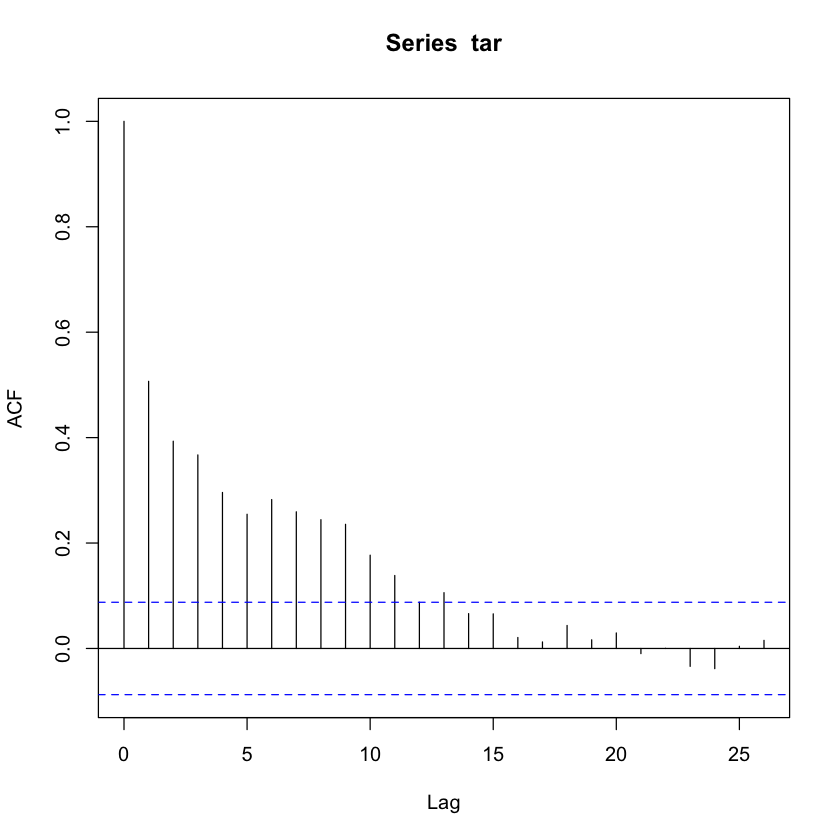

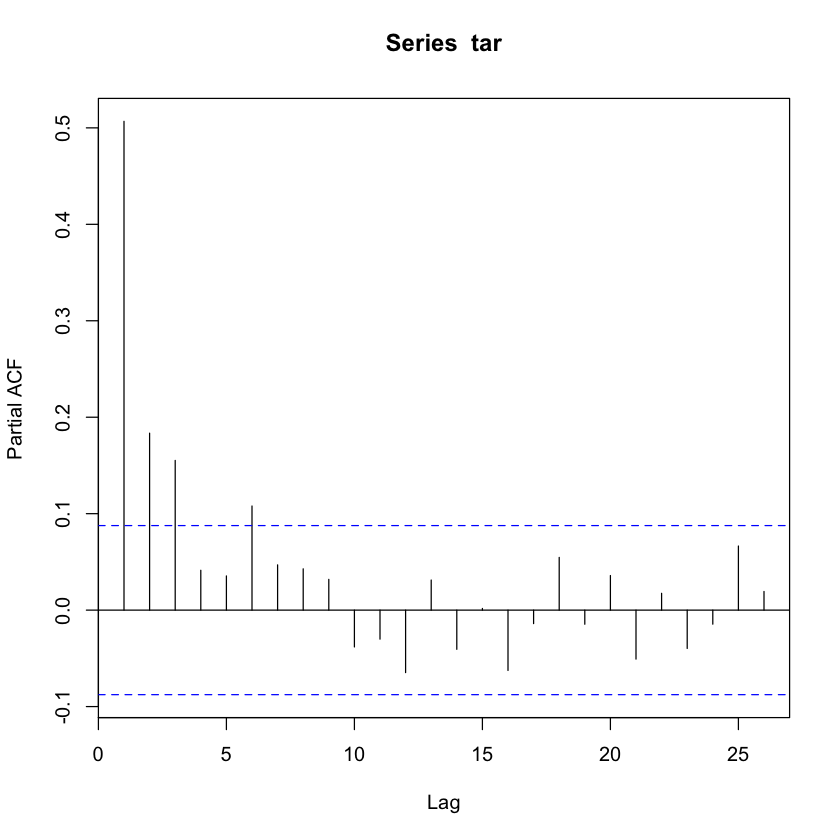

In [7]:
par(bg = 'white')

tar = data[,1]
acf(tar)
pacf(tar)

In [8]:
print(mean(tar))
print(mean(data[,1]))

[1] 0.1745526
[1] 0.1745526


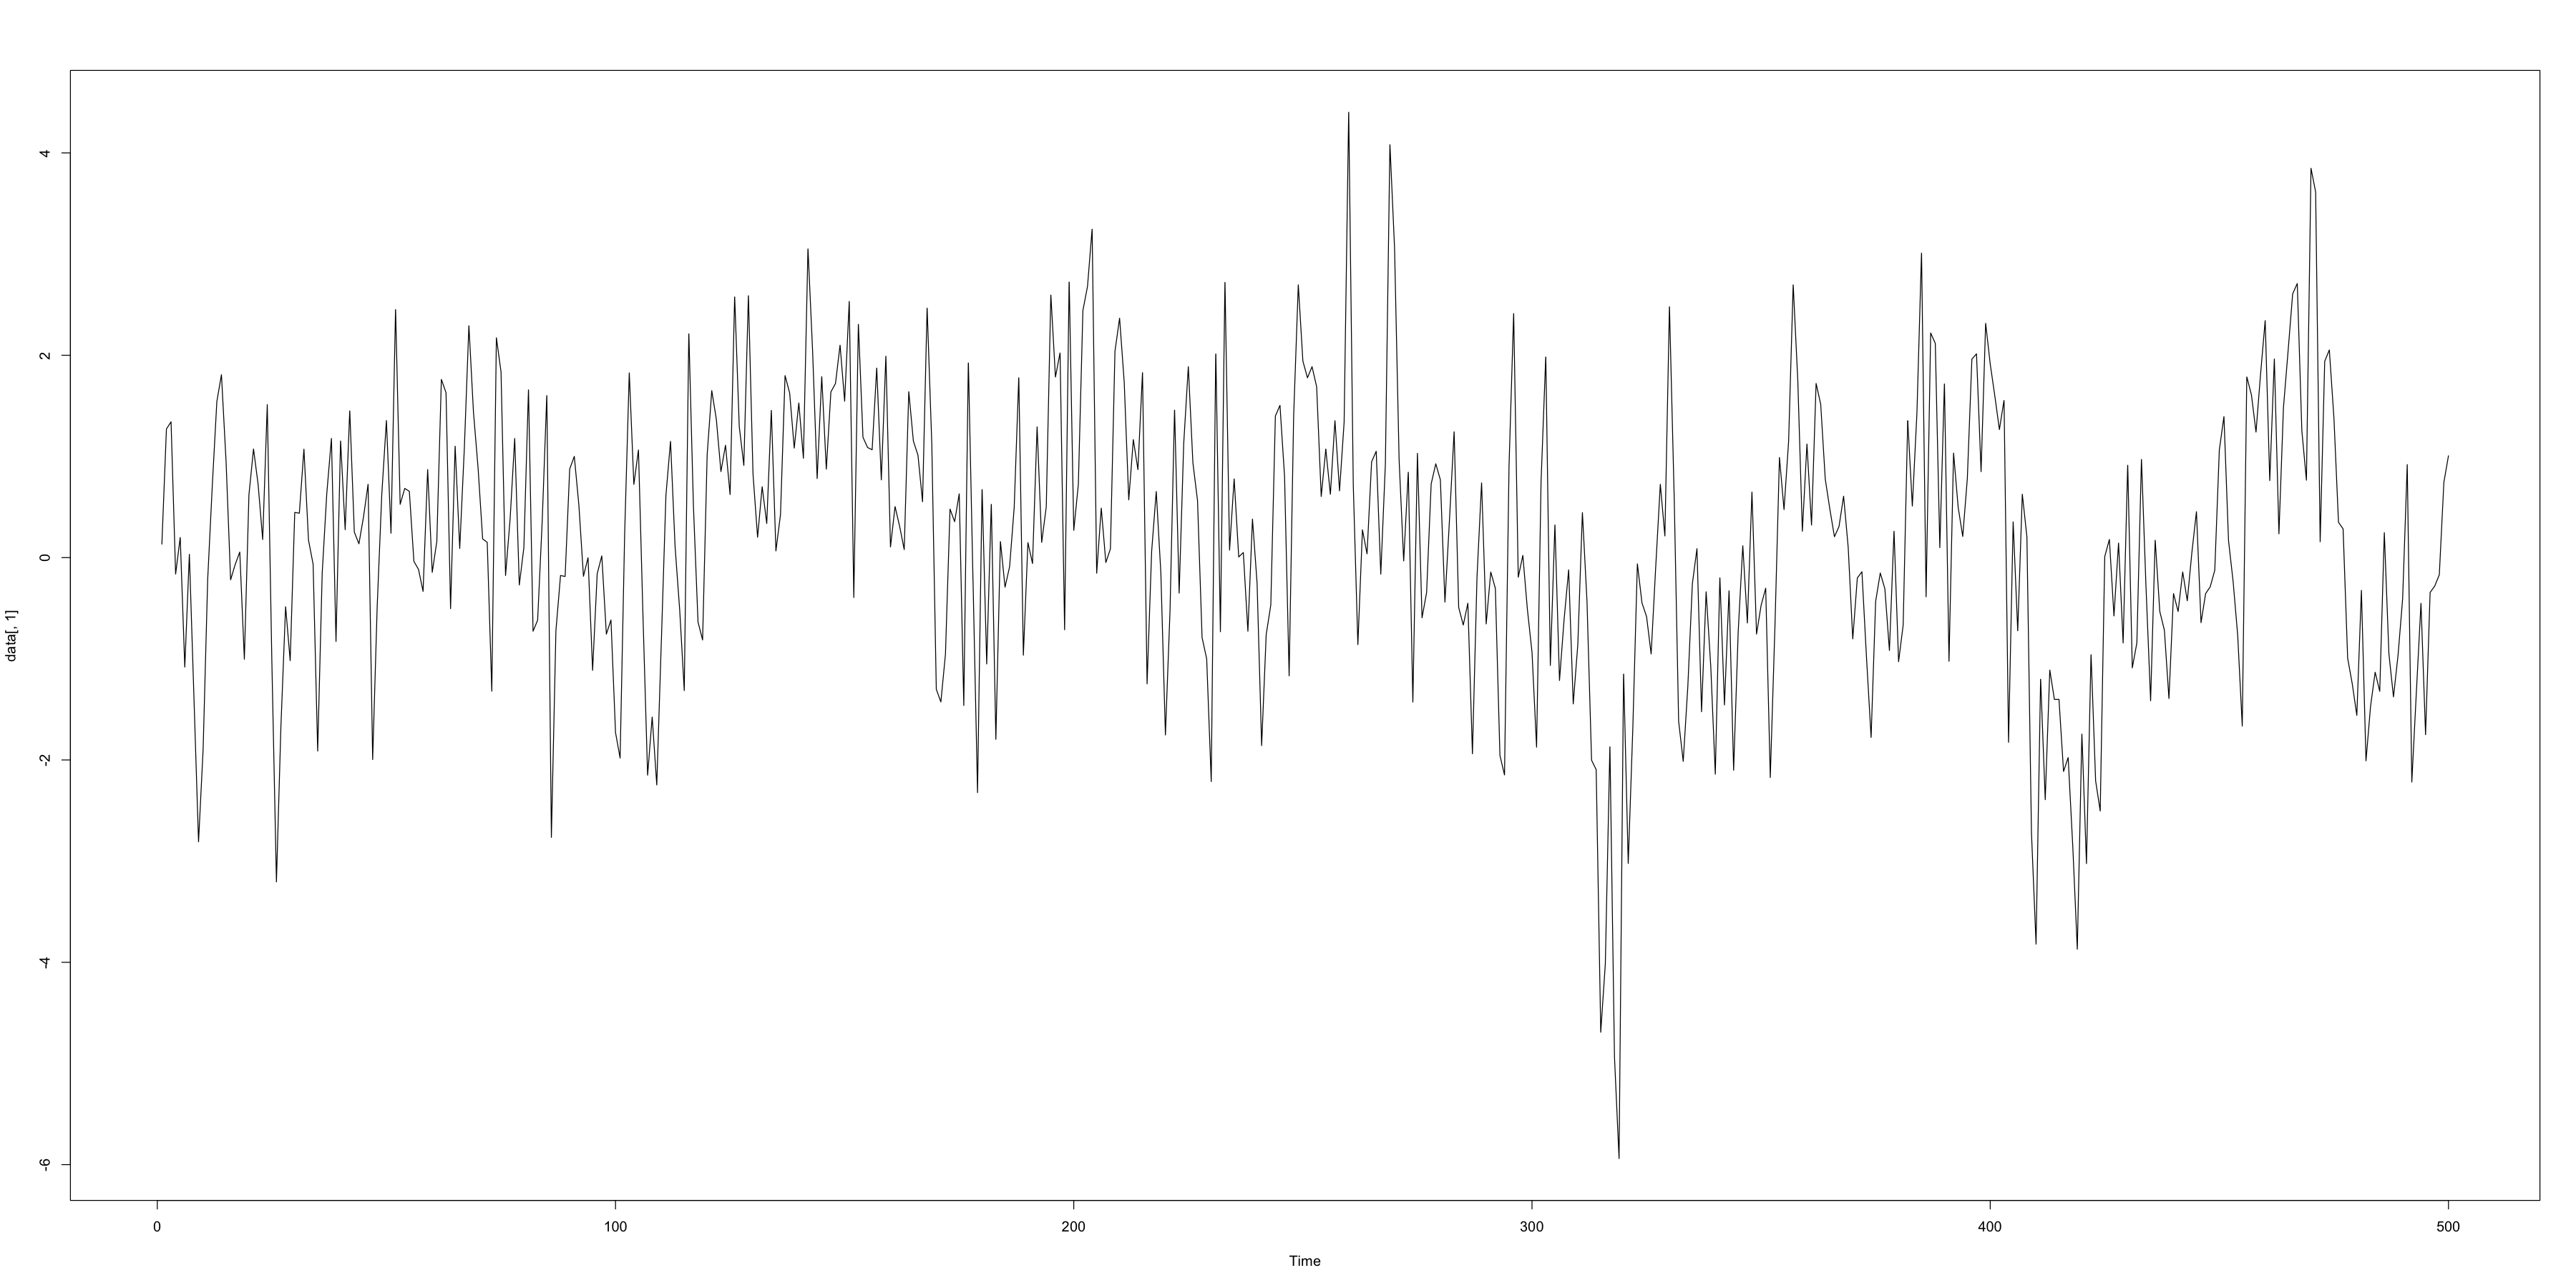

In [9]:
par(bg = "white")
options(repr.plot.width = 30, repr.plot.height = 15)

plot.ts(data[,1])

In [10]:
adf.test(data[,1], alternative = 'stationary')

Warning message in adf.test(data[, 1], alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  data[, 1]
Dickey-Fuller = -4.6565, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [11]:
Box.test(data[,1], lag = 22, type = "Ljung-Box")


	Box-Ljung test

data:  data[, 1]
X-squared = 527.89, df = 22, p-value < 2.2e-16


In [12]:
arma11_fit <- arima(data[,1], order = c(1, 0, 2), )

cat("ARMA(1,1) Model Details:\n")
report_model_details(arma11_fit)
cat("\n")

ARMA(1,1) Model Details:
Coefficients:
        ar1         ma1         ma2   intercept 
 0.89974156 -0.53159423 -0.09352971  0.17913694 
sigma^2: 1.35243 
Log-Likelihood: -785.1861 
AIC: 1580.372 
BIC: 1601.445 
c (computed as mu * (1 - phi)): 0.01795999 



In [13]:
auto_arima_fit = auto.arima(data[,1], stepwise = 0, approximation = 0, ic = "aicc", stationary = 1, )
print(auto_arima_fit)

Series: data[, 1] 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1      ma1      ma2
      0.9052  -0.5356  -0.0959
s.e.  0.0334   0.0568   0.0508

sigma^2 = 1.363:  log likelihood = -785.61
AIC=1579.21   AICc=1579.29   BIC=1596.07


In [14]:
library(glmnet)

X = data[, -1]
y = data[,1]
# Assuming 'y' is your dependent variable and 'X' is a matrix of independent variables (external regressors)
# Standardize X for LASSO
X_scaled <- scale(X)

# Fit LASSO model
set.seed(123) # For reproducibility
cv.lasso <- cv.glmnet(X_scaled, y, alpha = 1, family = "gaussian")

# Identify non-zero coefficients (selected variables)
selected_variables <- coef(cv.lasso, s = "lambda.min")

# Print the selected variables
print(selected_variables)

Caricamento del pacchetto richiesto: Matrix

Loaded glmnet 4.1-8



50 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept)  0.174552552
IMBFM        0.312259467
HPDYO       -0.069176915
KRZRU        .          
QHOTV        0.041794867
GODCT        0.047224167
NIYPB        .          
DWAMN        0.053352865
TBBPE        .          
XUPPP        .          
AZBCU        0.318505951
KFDTR        .          
ZKPGM        .          
KJWCK        0.018558725
ASQBO        .          
IFXBD        .          
MPHKC        .          
JTCKE        .          
XWCLI        0.036625746
VEGZF       -0.092270508
TGIYY        .          
HJHKS        0.019960604
ICFKP        .          
RBEQZ        0.021219828
KQRGK       -0.013223539
UKSKO        0.356638551
KIQMT        .          
EVYUN        0.042881089
ZZICN        0.056571019
QLSIM       -0.013797932
OIRTT        0.412815870
ILALU        .          
VMBWG        .          
CMYWF        .          
RVLSV        .          
BSZEI       -0.016056382
ZGUPA        .          
EGTZY   

In [15]:
non_zero_coef_indices <- which(selected_variables[-1, , drop = FALSE] != 0)
non_zero_coef_indices

[1]  1  2  4  5  7 10 13 18 19 21 23 24 25 27 28 29 30 35 39 43 44 46 47 49

In [16]:
exogenous = data[, -1]

spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(2,0), include.mean = TRUE, external.regressors = as.matrix(exogenous)),
                    distribution.model = "std")
garch_fit = ugarchfit(spec=spec, data=tar)

garchSpec = ugarchspec(
    variance.model=list(model="sGARCH",
                        garchOrder=c(1, 1)),
    mean.model=list(armaOrder=c(3,0), include.mean = TRUE, external.regressors = as.matrix(exogenous)), 
    distribution.model="std")
garchFit = ugarchfit(spec=garchSpec, data=tar)
# coef(garchFit)

garchFit_resid = residuals(garchFit)

garch_resid = residuals(garch_fit)

In [17]:
indices <- c(1,2,4,5,7,10,13,18,19,21,23,24,25,27,28,29,30,35,39,43,44,46,47,49)
indices = c(25)
data_select = exogenous[, indices]

garch_spec = ugarchspec(
    variance.model=list(model="sGARCH",
                        garchOrder=c(1, 1)),
    mean.model=list(armaOrder=c(0, 15), include.mean = TRUE, external.regressors = as.matrix(data_select)), 
    distribution.model="std")
garch_fit2 = ugarchfit(spec=garch_spec, data=tar)
garch_resid2 = residuals(garch_fit2)

In [18]:
arma11_resid = arma11_fit$residuals
cat("mean: ", mean(arma11_resid), '\n')
cat('var: ', var(arma11_resid), '\n')
cat('skewness: ', skewness(arma11_resid), '\n')
cat('kurtosis: ', kurtosis(arma11_resid), '\n')

mean:  -0.001039076 
var:  1.355139 
skewness:  -0.1191842 
kurtosis:  3.204512 


In [19]:
cat('mean: ', mean(garch_resid), '\n')
cat('var: ', var(garch_resid), '\n')
cat('skewness: ', skewness(garch_resid), '\n')
cat('kurtosis: ', kurtosis(garch_resid), '\n')

mean:  -0.01026104 
var:  0.6475443 
skewness:  0.0128141 
kurtosis:  2.958786 


In [20]:
cat('mean: ', mean(garchFit_resid), '\n')
cat('var: ', var(garchFit_resid), '\n')
cat('skewness: ', skewness(garchFit_resid), '\n')
cat('kurtosis: ', kurtosis(garchFit_resid), '\n')

mean:  -0.009737691 
var:  0.6487445 
skewness:  0.02578419 
kurtosis:  2.970368 


In [21]:
cat('mean: ', mean(garch_resid2), '\n')
cat('var: ', var(garch_resid2), '\n')
cat('skewness: ', skewness(garch_resid2), '\n')
cat('kurtosis: ', kurtosis(garch_resid2), '\n')

mean:  0.001251581 
var:  0.9600065 
skewness:  -0.01009659 
kurtosis:  3.062879 


In [22]:
Box.test(arma11_resid, lag = 22, type = "Ljung-Box")
Box.test(garch_resid, lag = 22, type = "Ljung-Box")
Box.test(garchFit_resid, lag = 22, type = "Ljung-Box")
Box.test(garch_resid2, lag = 22, type = "Ljung-Box")


	Box-Ljung test

data:  arma11_resid
X-squared = 14.411, df = 22, p-value = 0.8862



	Box-Ljung test

data:  garch_resid
X-squared = 22.105, df = 22, p-value = 0.4536



	Box-Ljung test

data:  garchFit_resid
X-squared = 21.858, df = 22, p-value = 0.4684



	Box-Ljung test

data:  garch_resid2
X-squared = 8.1038, df = 22, p-value = 0.9969


In [23]:
# Perform Ljung-Box test on ARMA(1,1) residuals
lb_arma11 <- Box.test(arma11_resid, lag = 22, type = "Ljung-Box")

# Check normality of residuals with a Shapiro-Wilk test
shapiro_arma11 <- shapiro.test(arma11_resid)

# Output the test results to support the claim
list(
    Ljung_Box_p_value = lb_arma11$p.value,
    Shapiro_Wilk_p_value = shapiro_arma11$p.value
)

$Ljung_Box_p_value
[1] 0.8862385

$Shapiro_Wilk_p_value
[1] 0.5427226

In [24]:
jarque.bera.test(arma11_resid)
jarque.bera.test(garch_resid)
jarque.bera.test(garchFit_resid)
jarque.bera.test(garch_resid2)


	Jarque Bera Test

data:  arma11_resid
X-squared = 2.0551, df = 2, p-value = 0.3579



	Jarque Bera Test

data:  garch_resid
X-squared = 0.04907, df = 2, p-value = 0.9758



	Jarque Bera Test

data:  garchFit_resid
X-squared = 0.073694, df = 2, p-value = 0.9638



	Jarque Bera Test

data:  garch_resid2
X-squared = 0.090864, df = 2, p-value = 0.9556


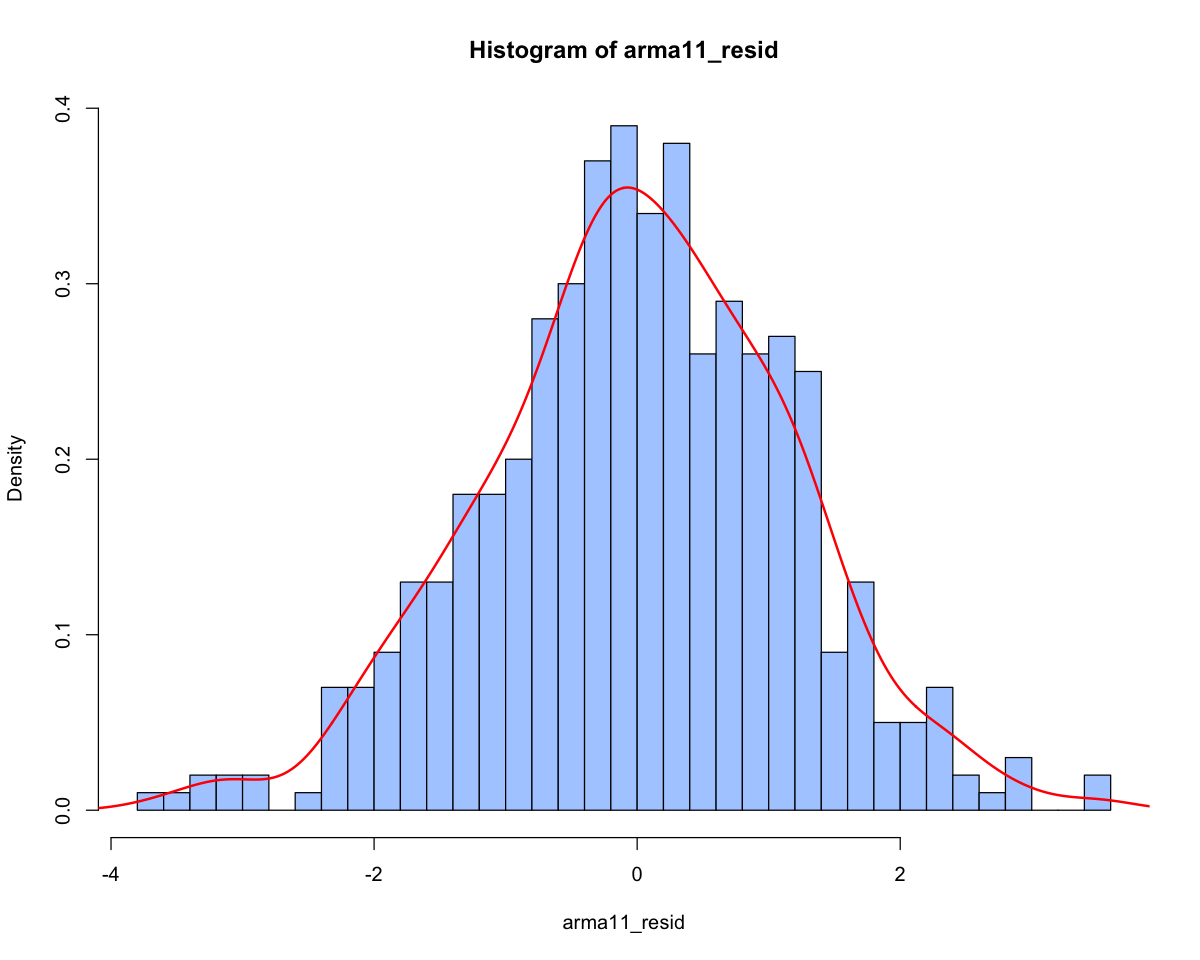

In [25]:
options(repr.plot.width = 10, repr.plot.height = 8)

par(bg = "white")

hist(arma11_resid, breaks = 50, freq = FALSE, col = '#afceff')
resid_density <- density(arma11_resid)
lines(resid_density, col = "#ff0000", lwd = 2)

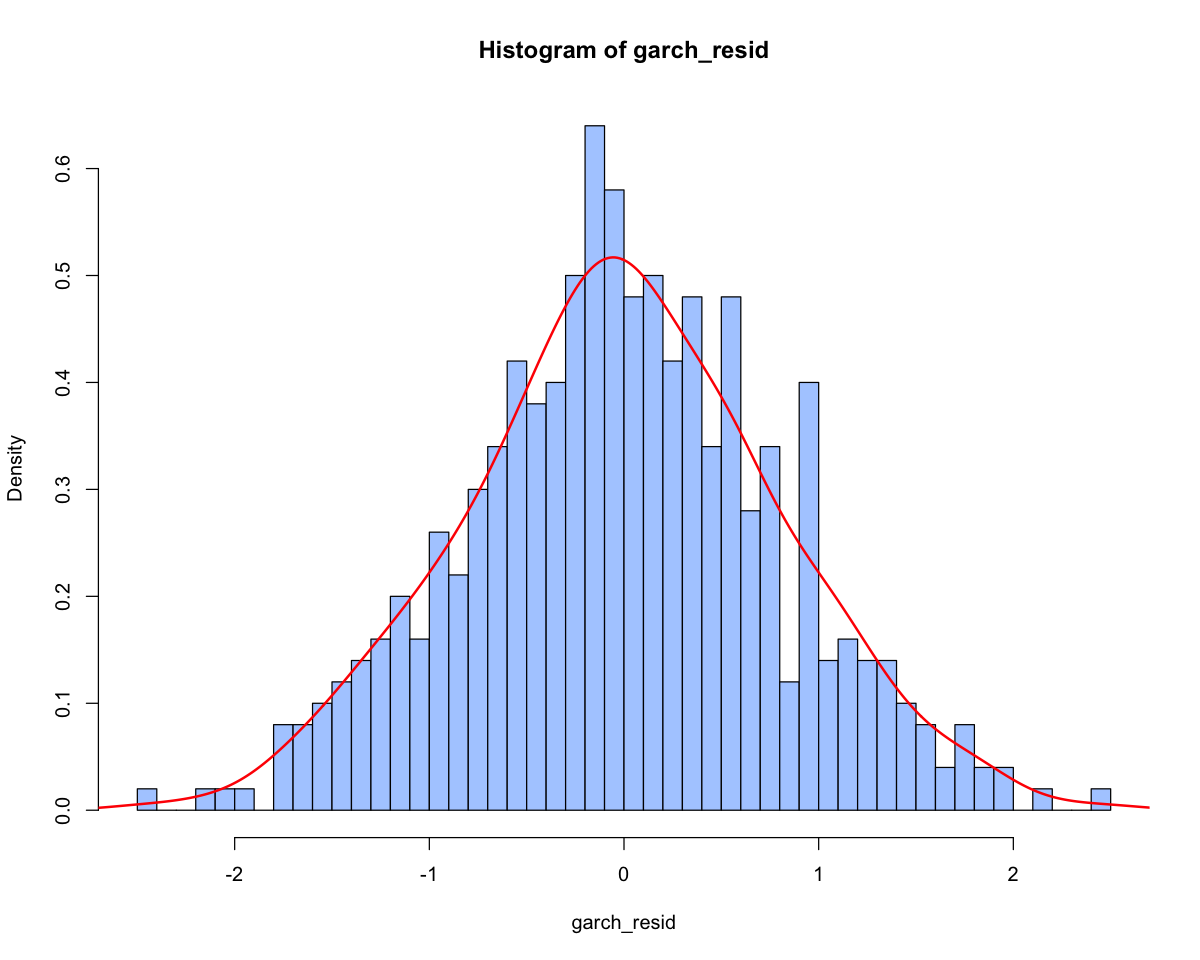

In [26]:
par(bg = "white")

hist(garch_resid, breaks = 50, freq = FALSE, col = '#afceff')
resid_density2 <- density(garch_resid)
lines(resid_density2, col = "#ff0000", lwd = 2)

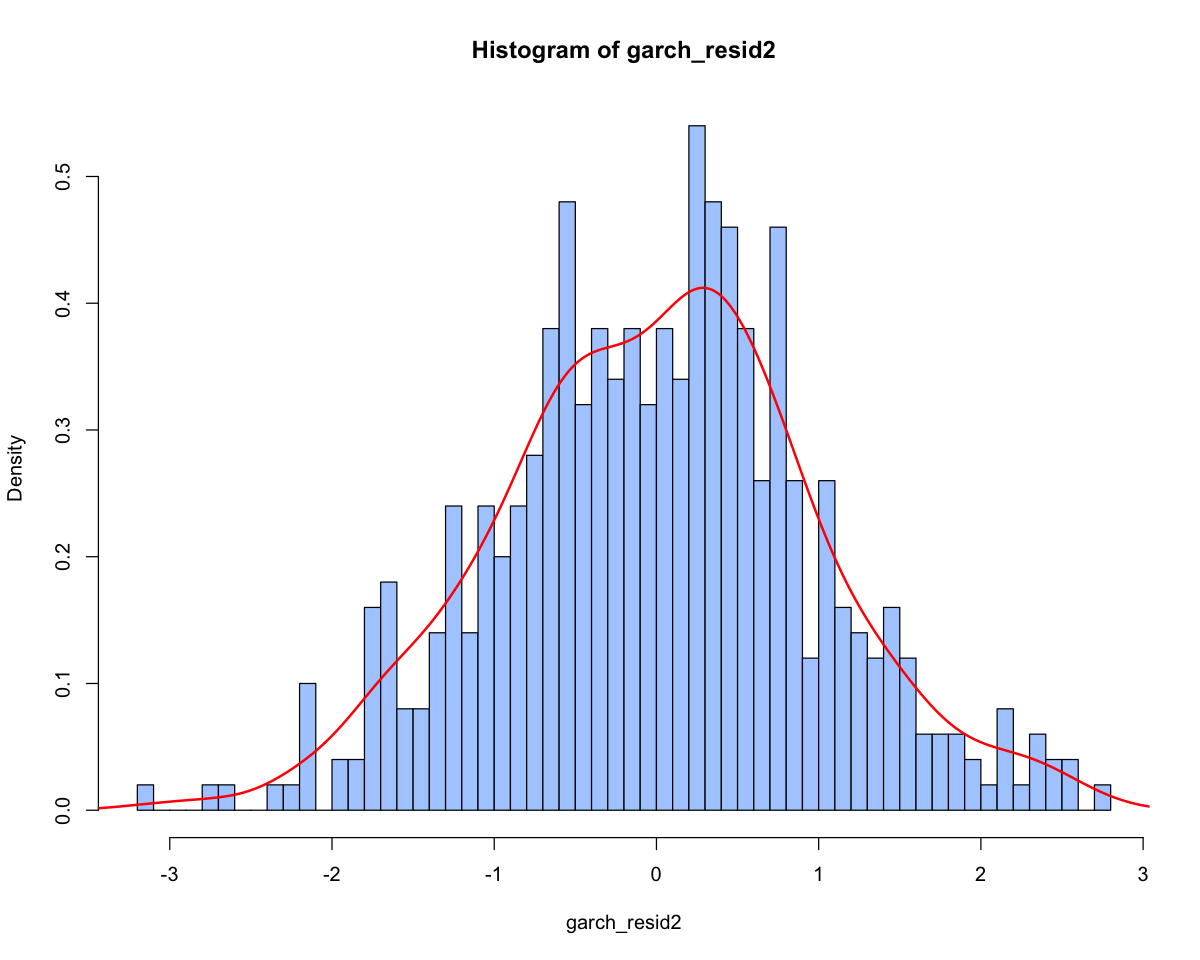

In [27]:
par(bg = "white")

hist(garch_resid2, breaks = 70, freq = FALSE, col = '#afceff')
resid_density4 <- density(garch_resid2)
lines(resid_density4, col = "#ff0000", lwd = 2)

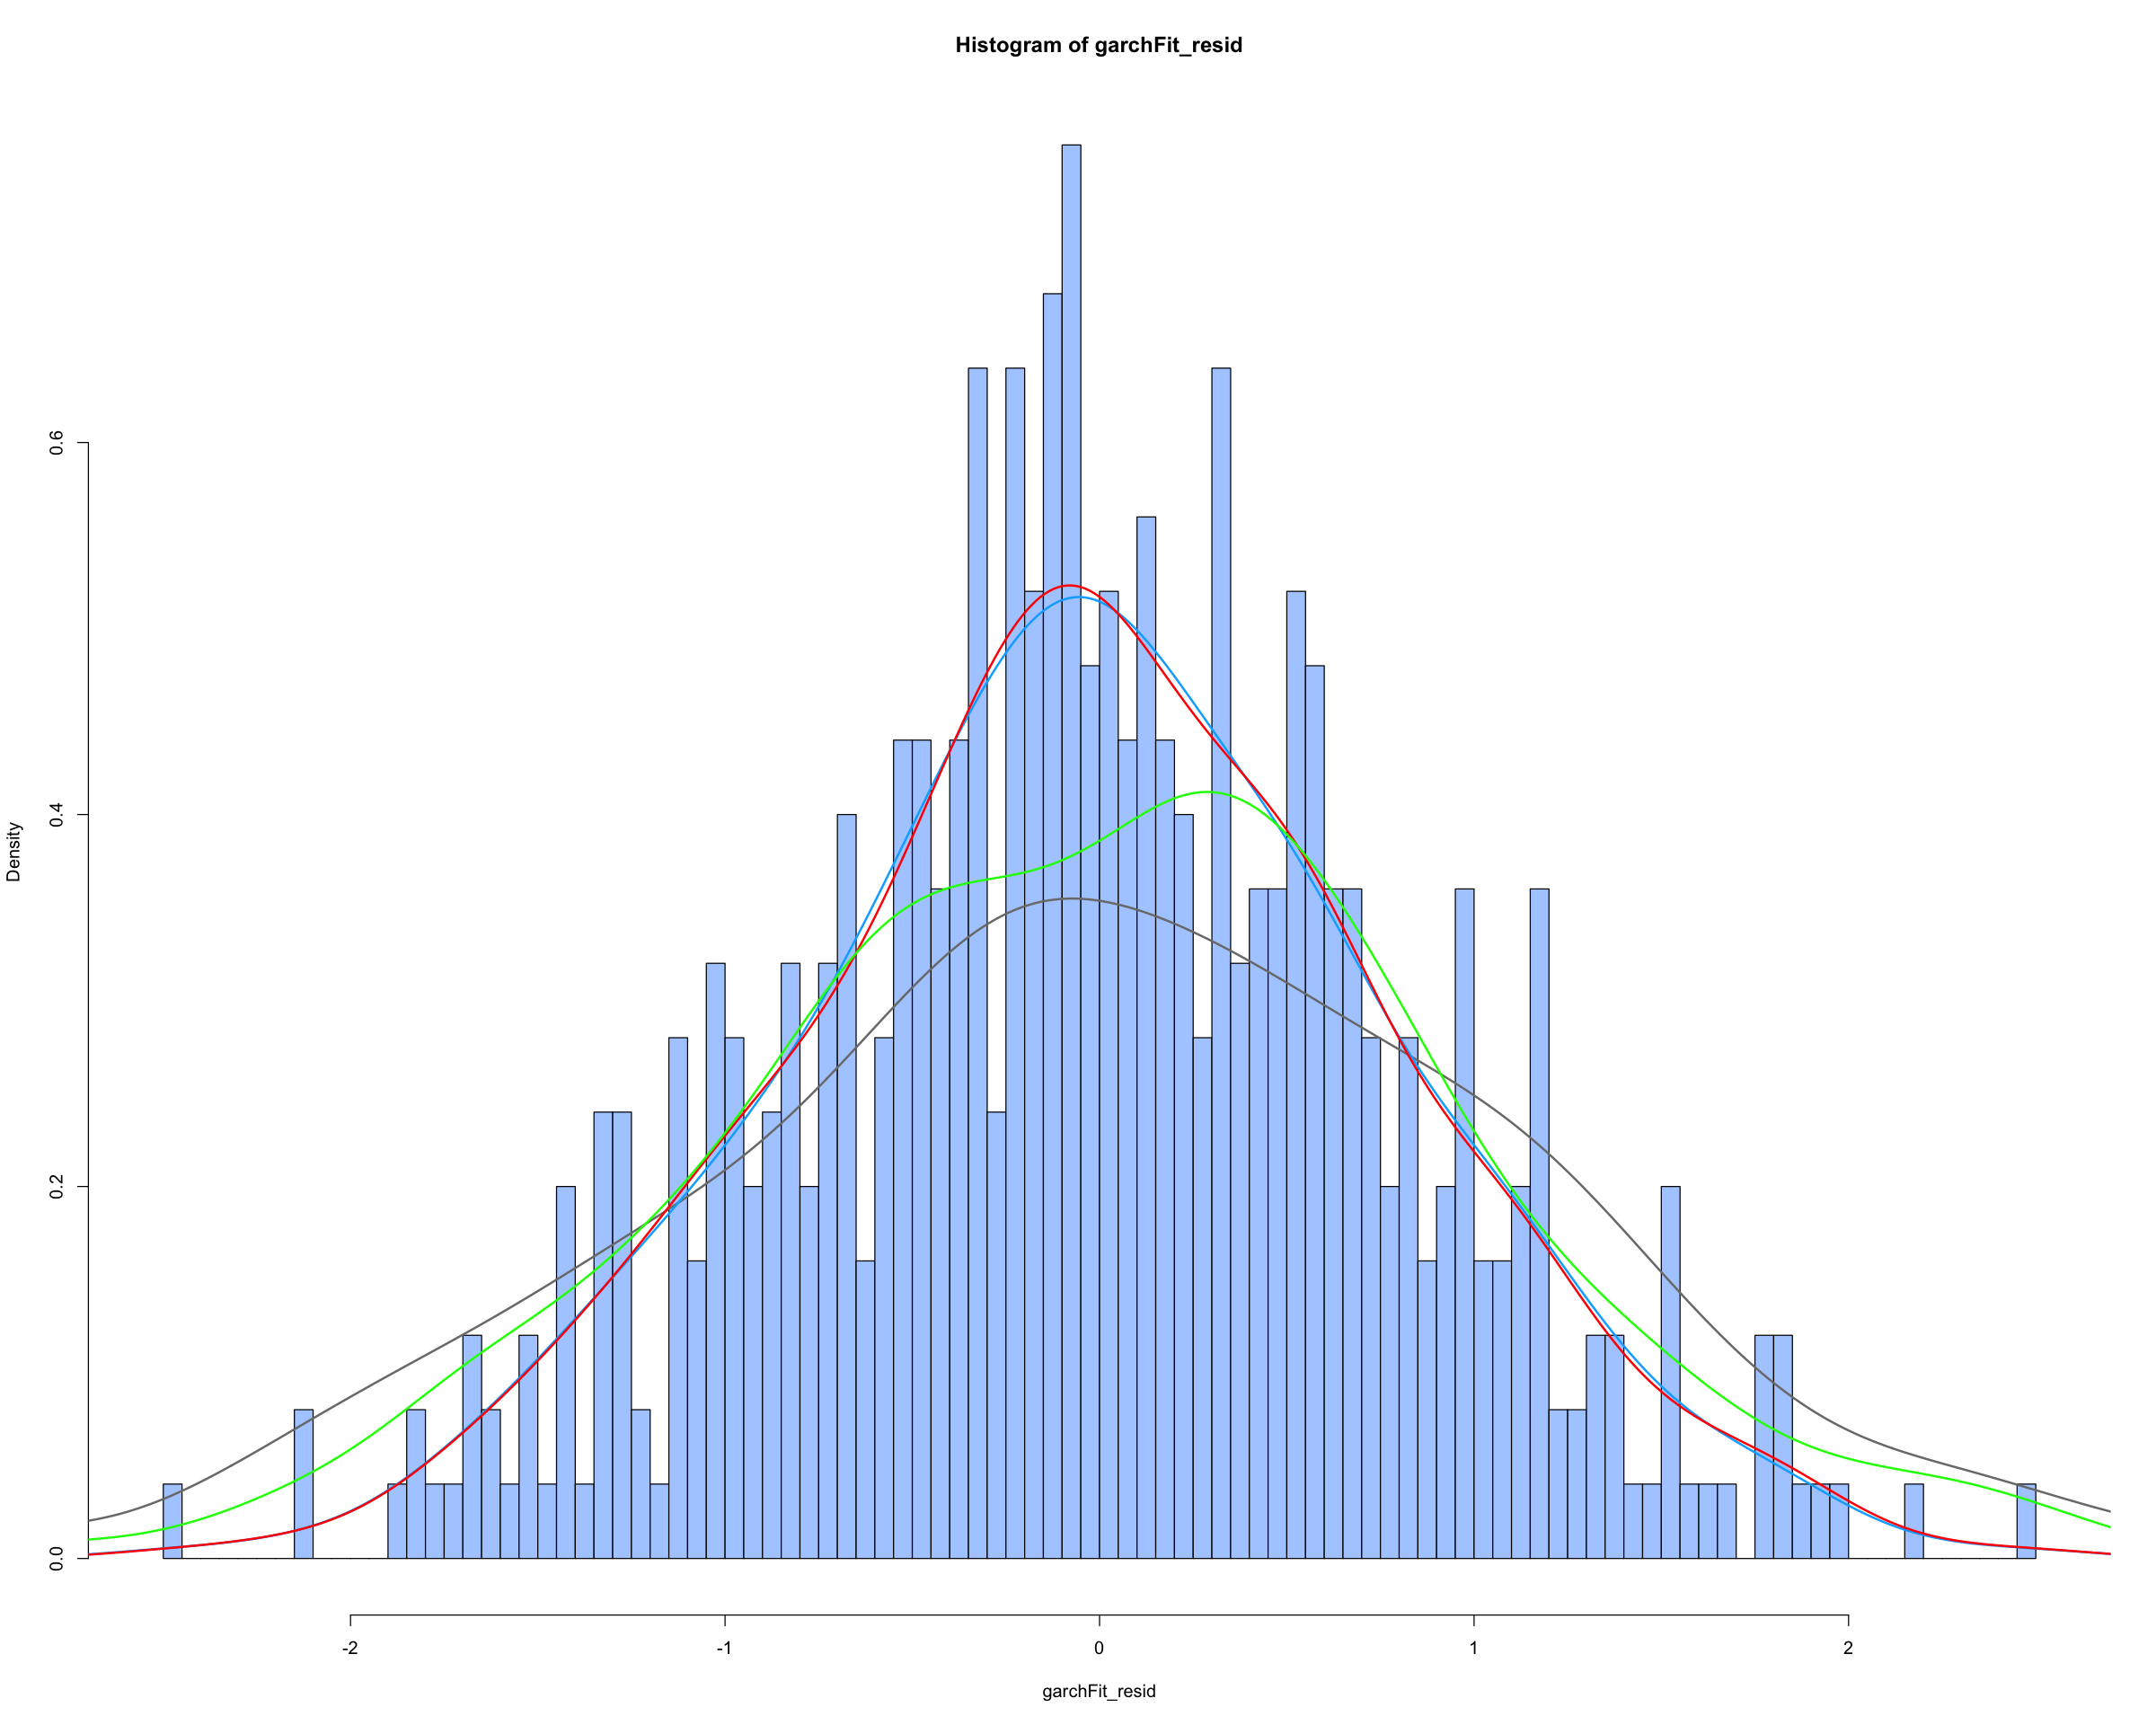

In [28]:
options(repr.plot.width = 20, repr.plot.height = 16)

par(bg = "white")

hist(garchFit_resid, breaks = 100, freq = FALSE, col = '#afceff')
resid_density3 <- density(garchFit_resid)
lines(resid_density, col = "#7b7b7b", lwd = 2)
lines(resid_density2, col = "#00aeff", lwd = 2)
lines(resid_density3, col = "#ff0000", lwd = 2)
lines(resid_density4, col = "#00ff00", lwd = 2)

In [33]:
predictor.pyARCH = function(y){
    install.packages("rugarch", quiet = TRUE)
    install.packages("forecast", quiet = TRUE)
    library(rugarch, quietly = TRUE)
    library(forecast, quietly = TRUE)
    library(tseries, quietly = TRUE)

    data = y[,-1]
    target = y[,1]
    n_periods = length(y)
    indices <- c(1,2,4,5,7,10,13,18,19,21,23,24,25,27,28,29,30,35,39,43,44,46,47,49)
    data_selected = data[, indices]
    # data = data_selected

    garch_specs = ugarchspec(
        variance.model=list(model="sGARCH", garchOrder=c(1, 1)), 
        mean.model=list(armaOrder=c(1, 1), include.mean = TRUE, external.regressors = as.matrix(data)), 
        distribution.model="std"
    )
    
    garch_fit = ugarchfit(spec=garch_specs, data=target)

    garch_residuals = residuals(garch_fit)

    print(Box.test(garch_residuals, lag = 22, type = "Ljung-Box"))
    cat('mean: ', mean(garch_residuals), '\n')
    cat('var: ', var(garch_residuals), '\n')
    cat('skewness: ', skewness(garch_residuals), '\n')
    cat('kurtosis: ', kurtosis(garch_residuals), '\n')
    print(jarque.bera.test(garch_residuals))

    forecast = ugarchforecast(garch_fit, n.ahead = 1, external.forecasts = list(mxreg = as.matrix(data)))

    # f = mean(target)

    f = as.numeric(forecast@forecast$seriesFor)

    return(f)
}

forecast_value = predictor.pyARCH(data)
print(forecast_value)


	Box-Ljung test

data:  garch_residuals
X-squared = 22.818, df = 22, p-value = 0.4121

mean:  -0.01067072 
var:  0.6494564 
skewness:  0.01858793 
kurtosis:  2.962752 

	Jarque Bera Test

data:  garch_residuals
X-squared = 0.057696, df = 2, p-value = 0.9716

[1] -0.03554226


In [30]:
X = data[, -1]
y = data[, 1]
indices = c(1,2,4,5,7,10,13,18,19,21,23,24,25,27,28,29,30,35,39,43,44,46,47,49)
X_sel = X[, indices]
X_25 = X[, c(24, 25)]

spec1 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(1,2), include.mean = TRUE, external.regressors = as.matrix(X)),
                    distribution.model = "std")
garch_fit1 = ugarchfit(spec=spec1, data=y)
garch_resid1 = residuals(garch_fit1)

spec2 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(3,0), include.mean = TRUE, external.regressors = as.matrix(X)),
                    distribution.model = "std")
garch_fit2 = ugarchfit(spec=spec2, data=y)
garch_resid2 = residuals(garch_fit2)

spec3 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(3,0), include.mean = TRUE, external.regressors = as.matrix(X_sel)),
                    distribution.model = "std")
garch_fit3 = ugarchfit(spec=spec3, data=y)
garch_resid3 = residuals(garch_fit3)

spec4 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(2,0), include.mean = TRUE, external.regressors = as.matrix(X)),
                    distribution.model = "std")
garch_fit4 = ugarchfit(spec=spec4, data=y)
garch_resid4 = residuals(garch_fit4)

spec5 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(1,1), include.mean = TRUE, external.regressors = as.matrix(X)),
                    distribution.model = "std")
garch_fit5 = ugarchfit(spec=spec5, data=y)
garch_resid5 = residuals(garch_fit5)

spec6 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(1,2), include.mean = TRUE, external.regressors = as.matrix(X_sel)),
                    distribution.model = "std")
garch_fit6 = ugarchfit(spec=spec6, data=y)
garch_resid6 = residuals(garch_fit6)

spec7 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(1,1), include.mean = TRUE, external.regressors = as.matrix(X_sel)),
                    distribution.model = "std")
garch_fit7 = ugarchfit(spec=spec7, data=y)
garch_resid7 = residuals(garch_fit7)

spec8 <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(2,0), include.mean = TRUE, external.regressors = as.matrix(X_sel)),
                    distribution.model = "std")
garch_fit8 = ugarchfit(spec=spec8, data=y)
garch_resid8 = residuals(garch_fit8)


Box.test(garch_resid1, lag = 22, type = "Ljung-Box")
Box.test(garch_resid2, lag = 22, type = "Ljung-Box")
Box.test(garch_resid3, lag = 22, type = "Ljung-Box")
Box.test(garch_resid4, lag = 22, type = "Ljung-Box")
Box.test(garch_resid5, lag = 22, type = "Ljung-Box")
Box.test(garch_resid6, lag = 22, type = "Ljung-Box")
Box.test(garch_resid7, lag = 22, type = "Ljung-Box")
Box.test(garch_resid8, lag = 22, type = "Ljung-Box")

print("#########################################")

jarque.bera.test(garch_resid1)
jarque.bera.test(garch_resid2)
jarque.bera.test(garch_resid3)
jarque.bera.test(garch_resid4)
jarque.bera.test(garch_resid5)
jarque.bera.test(garch_resid6)
jarque.bera.test(garch_resid7)
jarque.bera.test(garch_resid8)




	Box-Ljung test

data:  garch_resid1
X-squared = 22.211, df = 22, p-value = 0.4474



	Box-Ljung test

data:  garch_resid2
X-squared = 21.858, df = 22, p-value = 0.4684



	Box-Ljung test

data:  garch_resid3
X-squared = 20.988, df = 22, p-value = 0.5215



	Box-Ljung test

data:  garch_resid4
X-squared = 22.105, df = 22, p-value = 0.4536



	Box-Ljung test

data:  garch_resid5
X-squared = 22.818, df = 22, p-value = 0.4121



	Box-Ljung test

data:  garch_resid6
X-squared = 21.391, df = 22, p-value = 0.4967



	Box-Ljung test

data:  garch_resid7
X-squared = 21.919, df = 22, p-value = 0.4647



	Box-Ljung test

data:  garch_resid8
X-squared = 21.449, df = 22, p-value = 0.4931


[1] "#########################################"



	Jarque Bera Test

data:  garch_resid1
X-squared = 0.048424, df = 2, p-value = 0.9761



	Jarque Bera Test

data:  garch_resid2
X-squared = 0.073694, df = 2, p-value = 0.9638



	Jarque Bera Test

data:  garch_resid3
X-squared = 0.13823, df = 2, p-value = 0.9332



	Jarque Bera Test

data:  garch_resid4
X-squared = 0.04907, df = 2, p-value = 0.9758



	Jarque Bera Test

data:  garch_resid5
X-squared = 0.057696, df = 2, p-value = 0.9716



	Jarque Bera Test

data:  garch_resid6
X-squared = 0.11066, df = 2, p-value = 0.9462



	Jarque Bera Test

data:  garch_resid7
X-squared = 0.12921, df = 2, p-value = 0.9374



	Jarque Bera Test

data:  garch_resid8
X-squared = 0.11447, df = 2, p-value = 0.9444


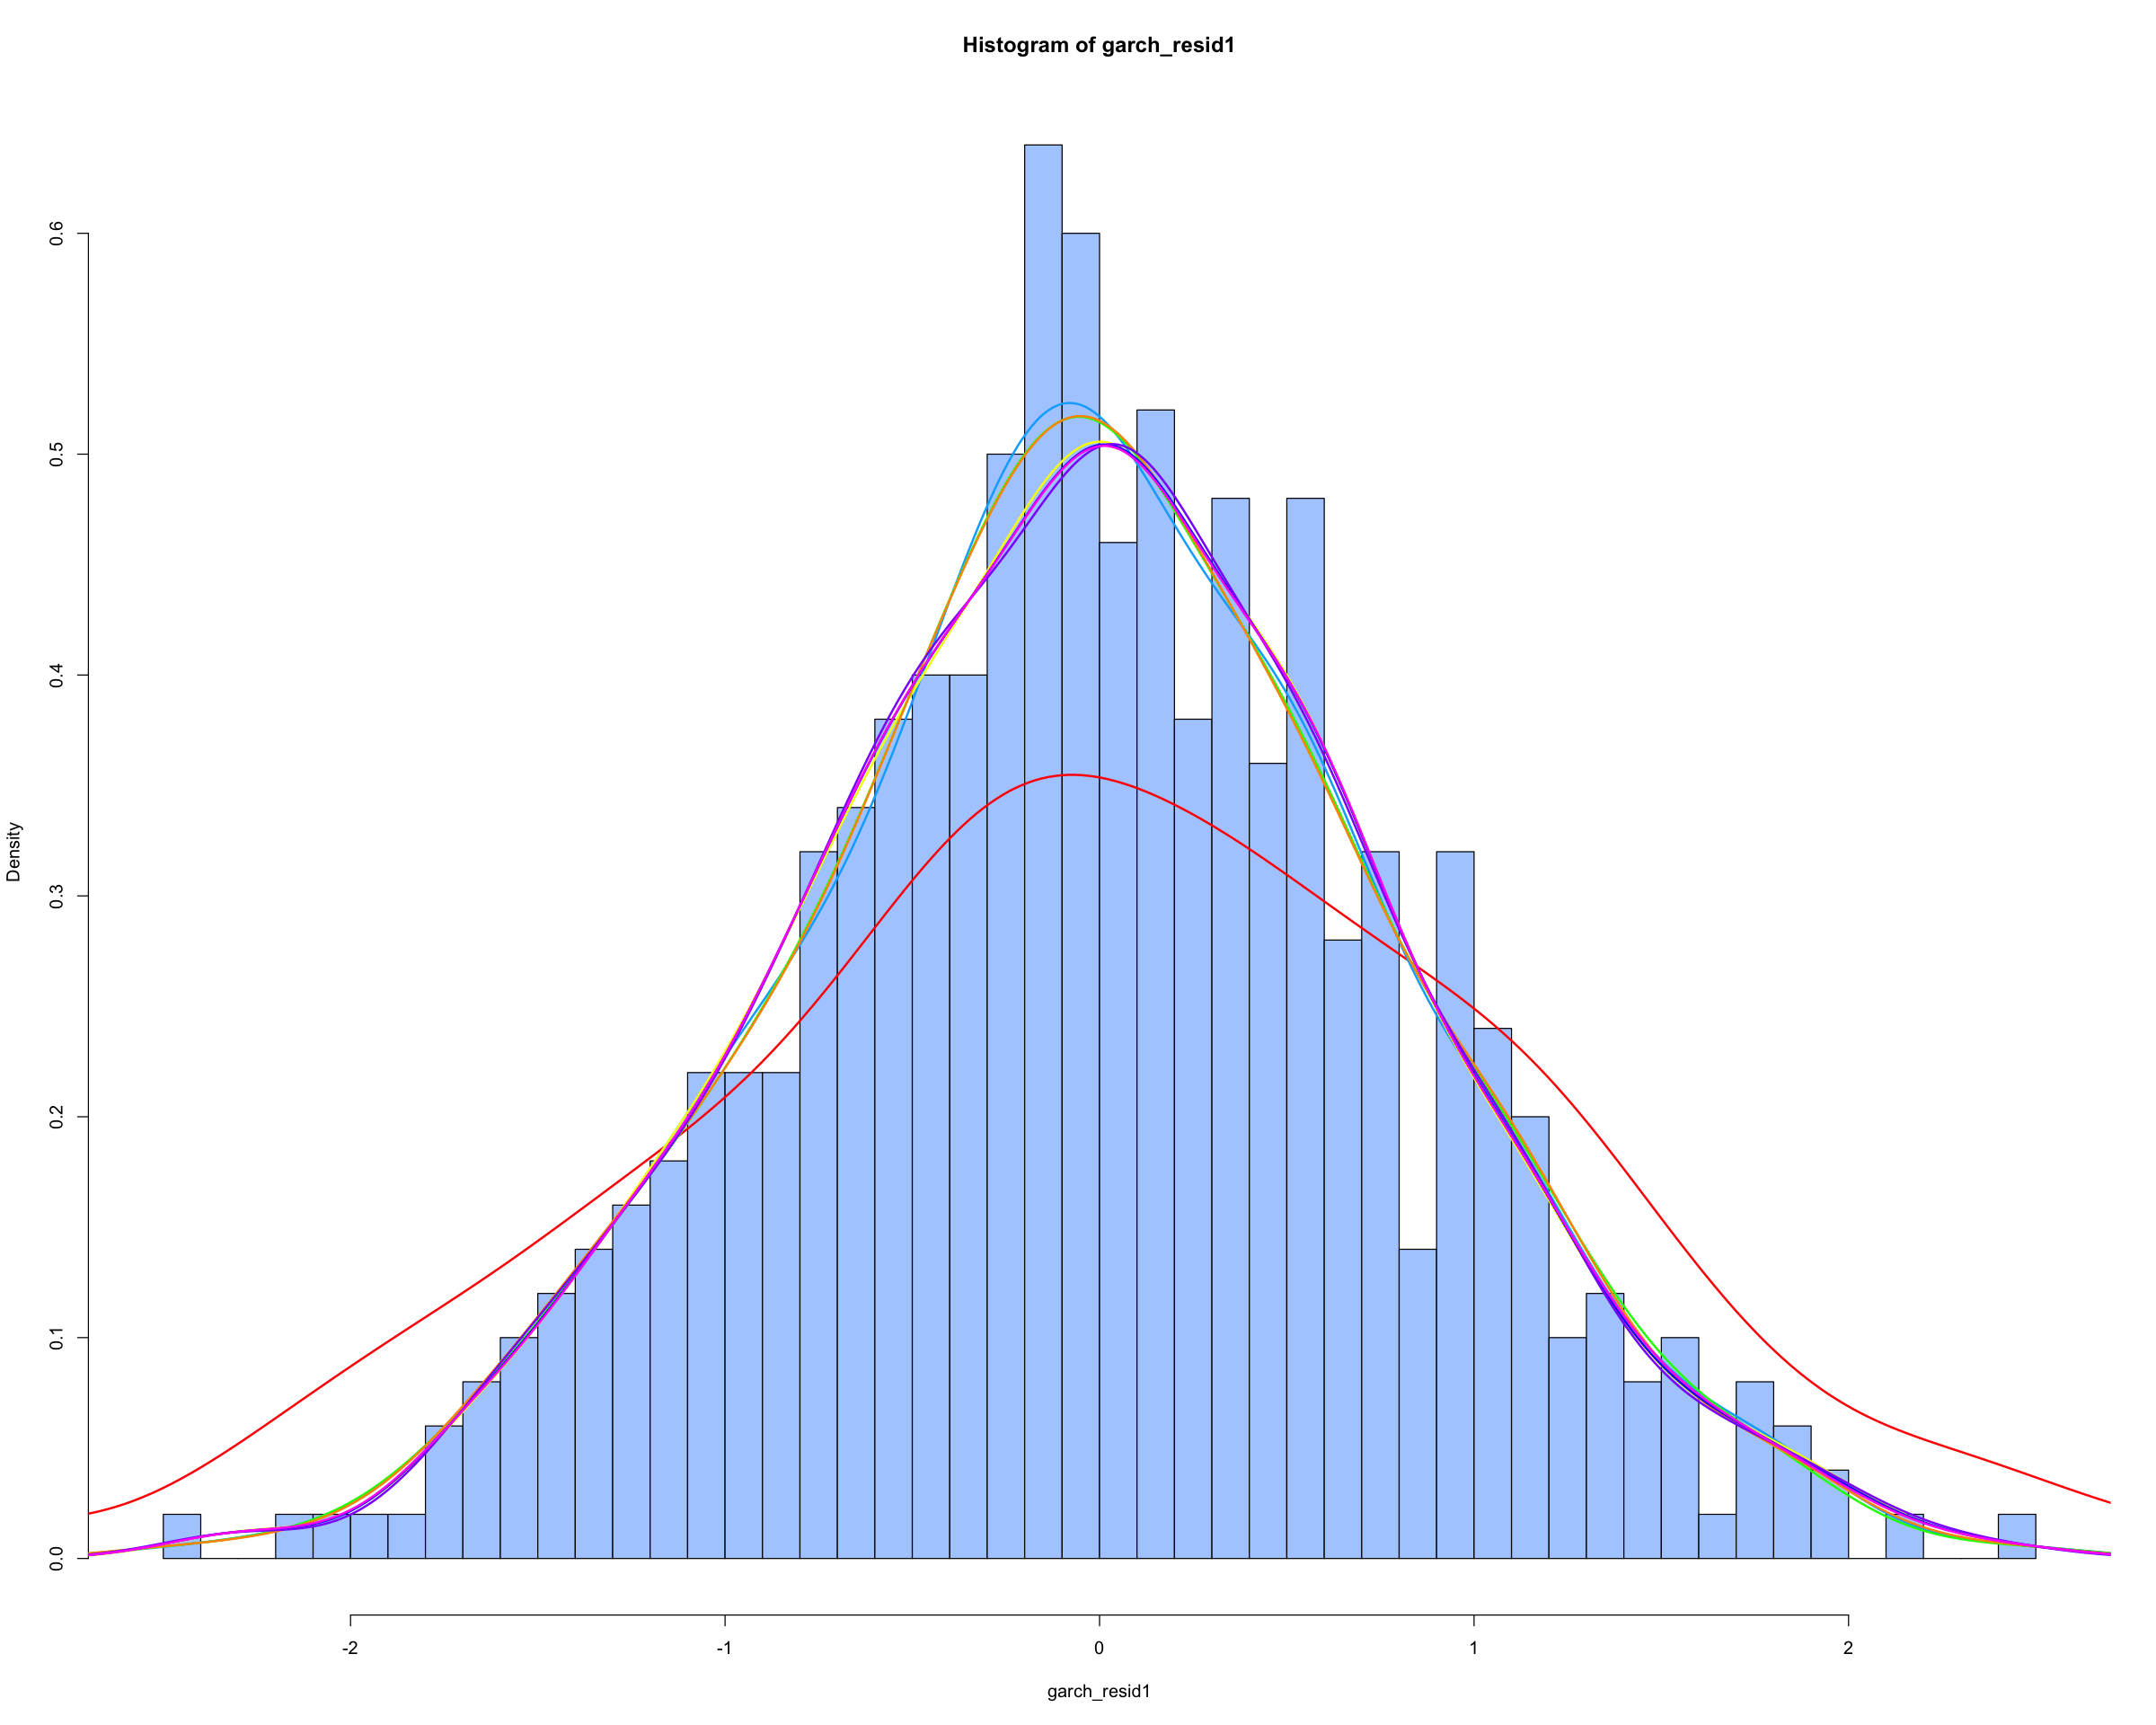

In [31]:
options(repr.plot.width = 20, repr.plot.height = 16)

par(bg = "white")

hist(garch_resid1, breaks = 50, freq = FALSE, col = '#afceff')


resid_density1 <- density(garch_resid1)
resid_density2 <- density(garch_resid2)
resid_density3 <- density(garch_resid3)
resid_density4 <- density(garch_resid4)
resid_density5 <- density(garch_resid5)
resid_density6 <- density(garch_resid6)
resid_density7 <- density(garch_resid7)
resid_density8 <- density(garch_resid8)



lines(resid_density, col = "#ff0000", lwd = 2)
lines(resid_density2, col = "#00aeff", lwd = 2)
lines(resid_density3, col = "#f6ff00", lwd = 2)
lines(resid_density4, col = "#00ff00", lwd = 2)
lines(resid_density5, col = "#ff9500", lwd = 2)
lines(resid_density6, col = "#1900ff", lwd = 2)
lines(resid_density7, col = "#8c00ff", lwd = 2)
lines(resid_density8, col = "#ff00f7", lwd = 2)

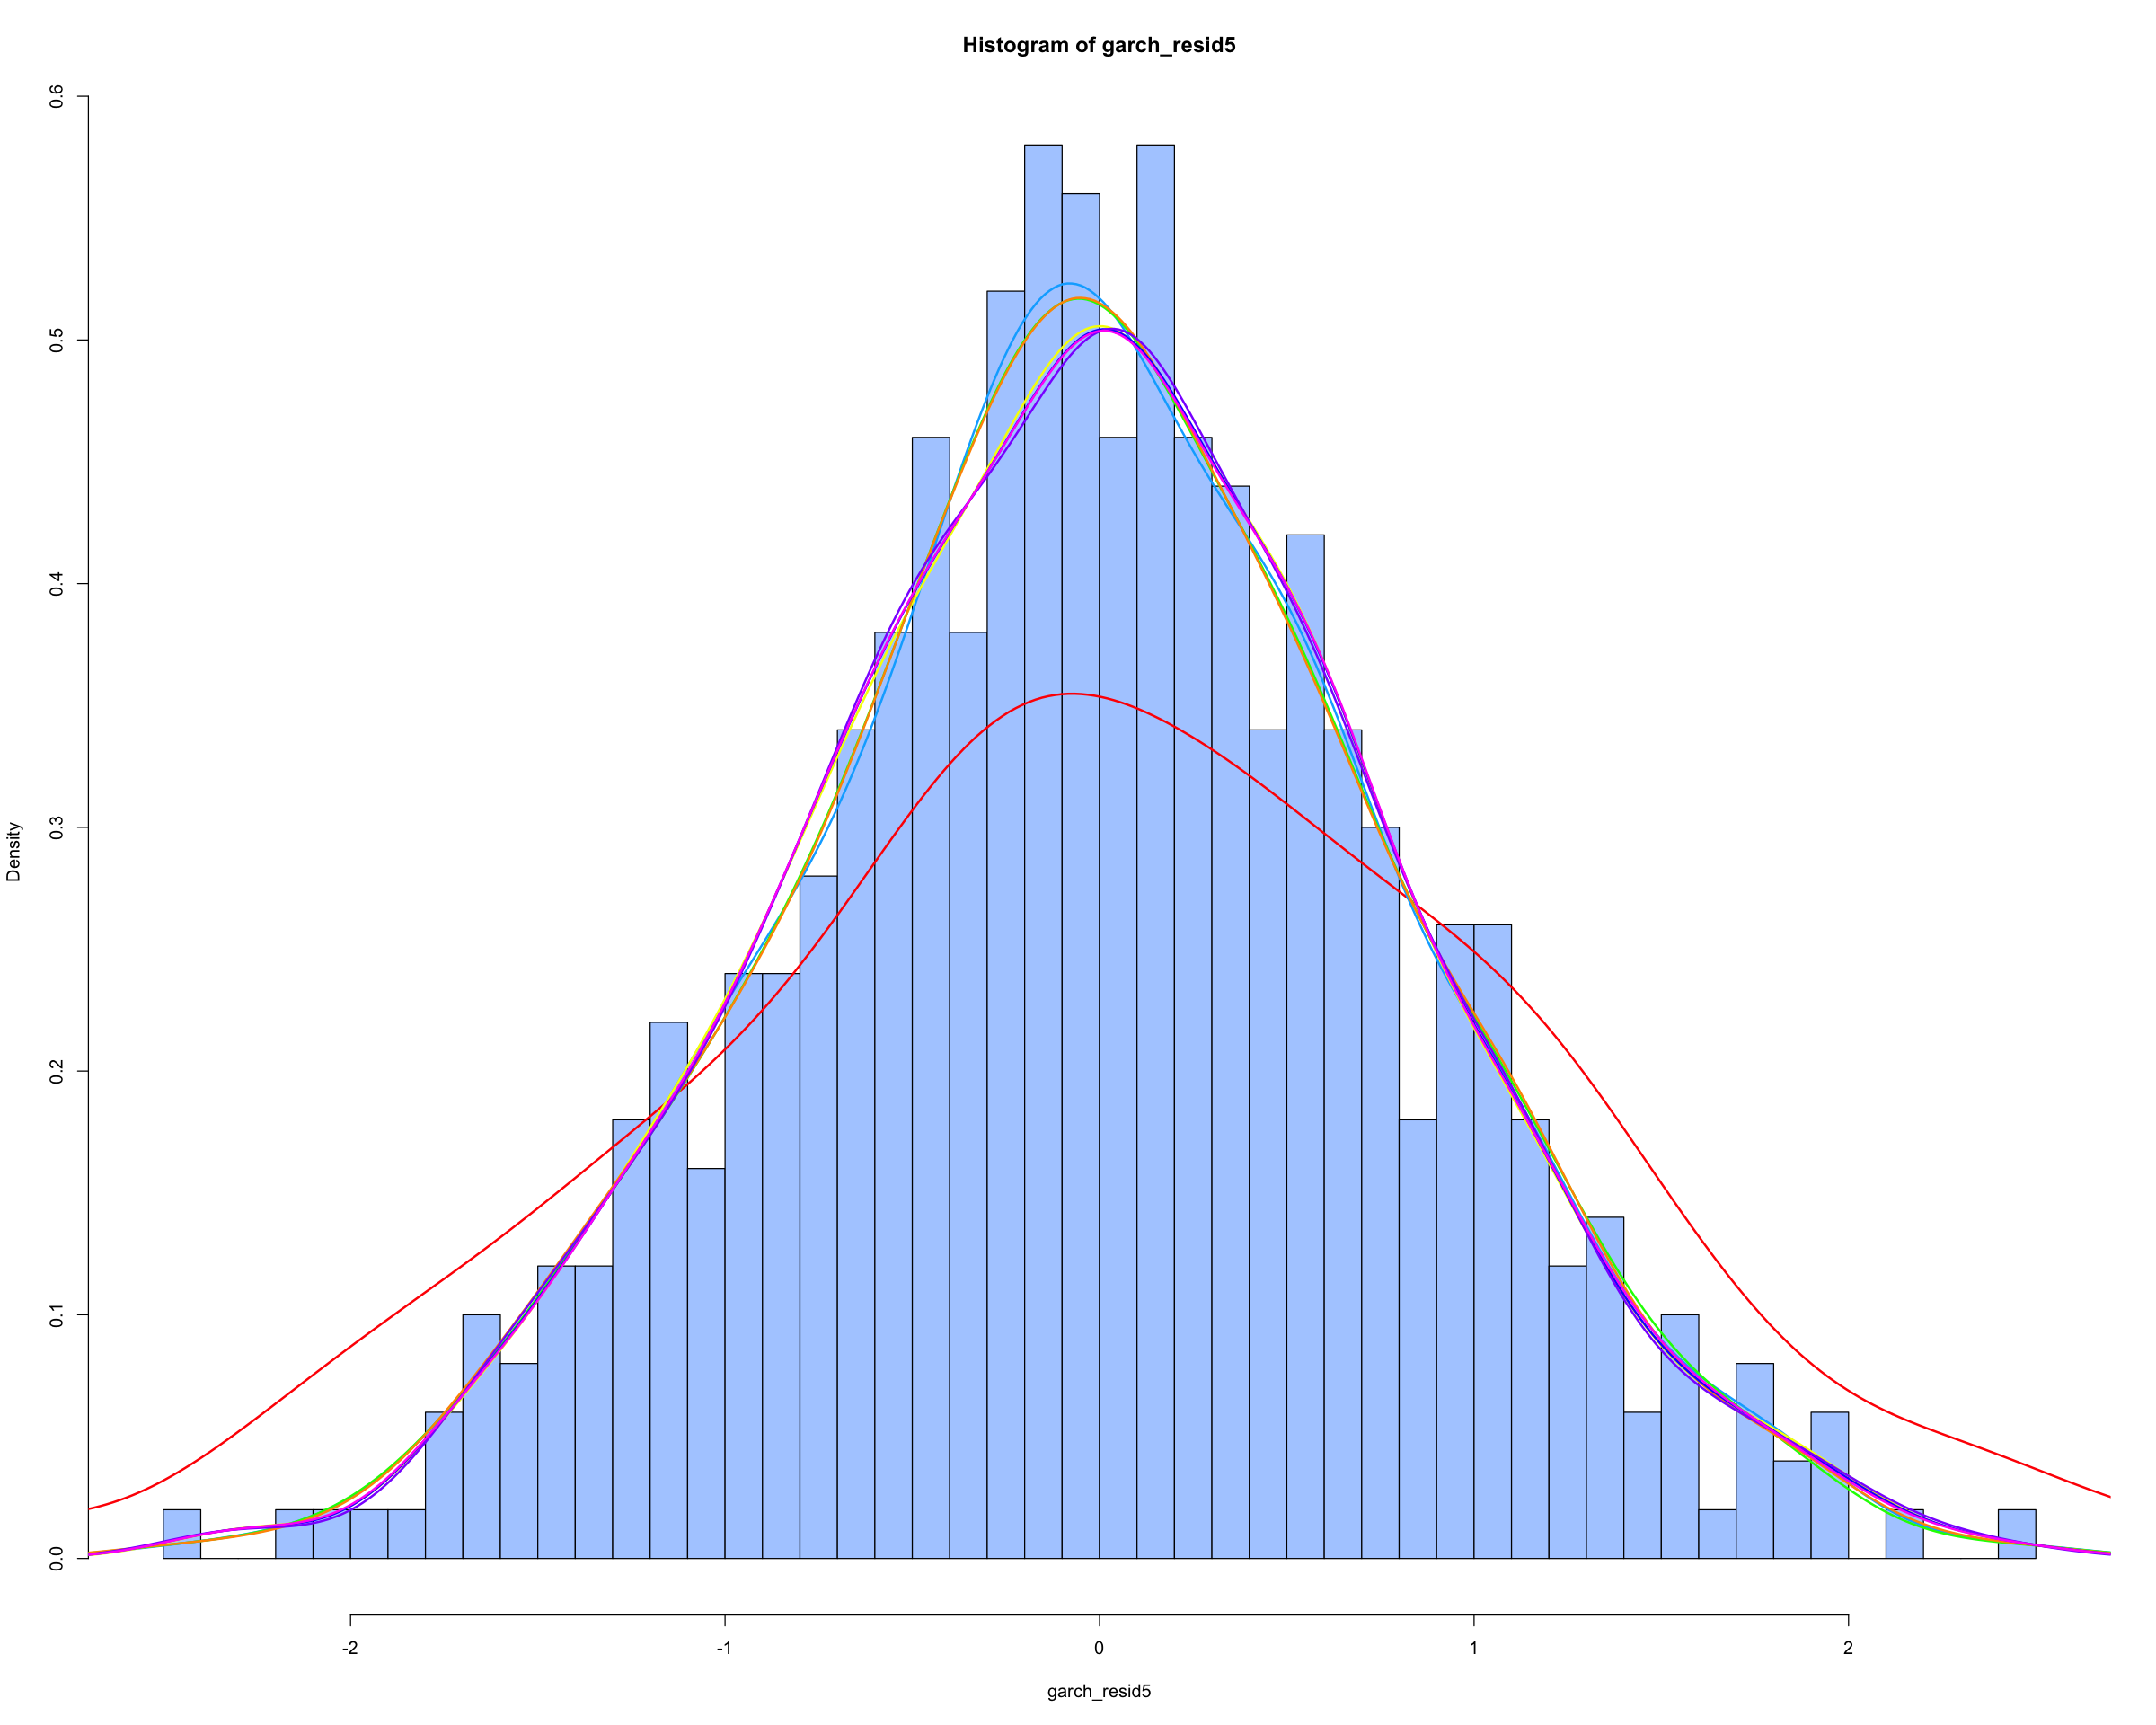

In [32]:
options(repr.plot.width = 20, repr.plot.height = 16)

par(bg = "white")

hist(garch_resid5, breaks = 50, freq = FALSE, col = '#afceff')


resid_density1 <- density(garch_resid1)
resid_density2 <- density(garch_resid2)
resid_density3 <- density(garch_resid3)
resid_density4 <- density(garch_resid4)
resid_density5 <- density(garch_resid5)
resid_density6 <- density(garch_resid6)
resid_density7 <- density(garch_resid7)
resid_density8 <- density(garch_resid8)



lines(resid_density, col = "#ff0000", lwd = 2)
lines(resid_density2, col = "#00aeff", lwd = 2)
lines(resid_density3, col = "#f6ff00", lwd = 2)
lines(resid_density4, col = "#00ff00", lwd = 2)
lines(resid_density5, col = "#ff9500", lwd = 2)
lines(resid_density6, col = "#1900ff", lwd = 2)
lines(resid_density7, col = "#8c00ff", lwd = 2)
lines(resid_density8, col = "#ff00f7", lwd = 2)